<a href="https://colab.research.google.com/github/tas0931/Music_Clustering_CSE425/blob/main/code%20(src)/Copy_of_medium_tasks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Cell 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Cell 2: Install Required Libraries
!pip install -q sentence-transformers
!pip install -q umap-learn
!pip install -q scikit-learn
!pip install -q librosa
!pip install -q matplotlib
!pip install -q seaborn

print(" All libraries installed!")

 All libraries installed!


In [ ]:
# Cell 3: Import Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pickle
import warnings
warnings.filterwarnings('ignore')

# Deep Learning
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

# NLP for lyrics embeddings
from sentence_transformers import SentenceTransformer

# Clustering
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Metrics
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score,
    adjusted_rand_score
)

# Visualization
from sklearn.manifold import TSNE
import umap

# Set seeds
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

print(" All libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

 All libraries imported successfully!
PyTorch version: 2.9.0+cpu
CUDA available: False


In [ ]:
# Cell 4: Load Audio Features from Easy Task
print("=" * 70)
print("LOADING AUDIO FEATURES FROM EASY TASK")
print("=" * 70)

# Load the saved results from Easy Task
easy_task_path = '/content/drive/MyDrive/cse425 datasets/vae_clustering_results.pkl'

if os.path.exists(easy_task_path):
    with open(easy_task_path, 'rb') as f:
        easy_task_results = pickle.load(f)

    X_audio = easy_task_results['X_scaled']  # Normalized audio features
    audio_files = easy_task_results['audio_files']

    print(f" Audio features loaded!")
    print(f"  Shape: {X_audio.shape}")
    print(f"  Files: {len(audio_files)}")
else:
    print(f" Easy task results not found at: {easy_task_path}")

LOADING AUDIO FEATURES FROM EASY TASK
 Audio features loaded!
  Shape: (2294, 40)
  Files: 2294


In [ ]:
# Cell 5: Load Lyrics Data
print("=" * 70)
print("LOADING LYRICS DATA")
print("=" * 70)

# Load lyrics data
lyrics_pkl_path = '/content/drive/MyDrive/cse425 datasets/lyrics_data.pkl'

if os.path.exists(lyrics_pkl_path):
    lyrics_df = pd.read_pickle(lyrics_pkl_path)
    print(f" Lyrics data loaded!")
    print(f"  Total lyrics: {len(lyrics_df)}")
    print(f"  Average words: {lyrics_df['word_count'].mean():.1f}")
    print()
    print(lyrics_df.head())
else:
    print(f" Lyrics data not found at: {lyrics_pkl_path}")

LOADING LYRICS DATA
 Lyrics data loaded!
  Total lyrics: 1910
  Average words: 25.2

                                          audio_file folder    filename  \
0  /content/drive/MyDrive/cse425 datasets/FMA_Dat...    050  050272.mp3   
1  /content/drive/MyDrive/cse425 datasets/FMA_Dat...    050  050276.mp3   
2  /content/drive/MyDrive/cse425 datasets/FMA_Dat...    050  050283.mp3   
3  /content/drive/MyDrive/cse425 datasets/FMA_Dat...    050  050444.mp3   
4  /content/drive/MyDrive/cse425 datasets/FMA_Dat...    050  050445.mp3   

                                              lyrics  \
0  Come and catch my soul, boy you're lying, I'm ...   
1  your rules and repairing for the day. When all...   
2  Let's grab the vibes in the rain and ragassant...   
3  것앞음낍laimer is my way whatever i get но quanto ...   
4            Those indần mixed with the exactly same   

                                         lyrics_file  word_count  
0  /content/drive/MyDrive/cse425 datasets/extract...        

In [ ]:
# Cell 6: Align Audio and Lyrics Data
print("=" * 70)
print("ALIGNING AUDIO AND LYRICS DATA")
print("=" * 70)

# Create mapping of audio files to lyrics
lyrics_dict = lyrics_df.set_index('audio_file')['lyrics'].to_dict()

# Find matching audio files that have lyrics
matched_data = []
matched_audio_features = []
matched_lyrics = []

for idx, audio_file in enumerate(audio_files):
    if audio_file in lyrics_dict:
        matched_data.append({
            'audio_file': audio_file,
            'lyrics': lyrics_dict[audio_file],
            'audio_features': X_audio[idx]
        })
        matched_audio_features.append(X_audio[idx])
        matched_lyrics.append(lyrics_dict[audio_file])

# Convert to arrays
X_audio_aligned = np.array(matched_audio_features)
lyrics_aligned = matched_lyrics

print(f" Data alignment complete!")
print(f"  Matched samples: {len(matched_data)}")
print(f"  Audio features shape: {X_audio_aligned.shape}")
print(f"  Lyrics count: {len(lyrics_aligned)}")
print()
print(f"Match rate: {len(matched_data)/len(audio_files)*100:.1f}%")

ALIGNING AUDIO AND LYRICS DATA
 Data alignment complete!
  Matched samples: 1910
  Audio features shape: (1910, 40)
  Lyrics count: 1910

Match rate: 83.3%


In [ ]:
# Cell 7: Generate Lyrics Embeddings using Sentence Transformers
print("=" * 70)
print("GENERATING LYRICS EMBEDDINGS")
print("=" * 70)
print()

# Load pre-trained sentence transformer model
# Options: 'all-MiniLM-L6-v2' (fast), 'all-mpnet-base-v2' (better quality)
model_name = 'all-MiniLM-L6-v2'
print(f"Loading model: {model_name}")
print("This may take a minute on first load...")

embedding_model = SentenceTransformer(model_name)

print(f" Model loaded!")
print(f"  Embedding dimension: {embedding_model.get_sentence_embedding_dimension()}")
print()

# Generate embeddings for all lyrics
print("Generating embeddings for all lyrics...")
print("This may take a few minutes...")

lyrics_embeddings = embedding_model.encode(
    lyrics_aligned,
    show_progress_bar=True,
    batch_size=32,
    convert_to_numpy=True
)

print()
print(f"  Lyrics embeddings generated!")
print(f"  Shape: {lyrics_embeddings.shape}")
print(f"  Embedding dimension: {lyrics_embeddings.shape[1]}")

# Normalize lyrics embeddings
from sklearn.preprocessing import StandardScaler
lyrics_scaler = StandardScaler()
X_lyrics_normalized = lyrics_scaler.fit_transform(lyrics_embeddings)

print(f" Lyrics embeddings normalized")

GENERATING LYRICS EMBEDDINGS

Loading model: all-MiniLM-L6-v2
This may take a minute on first load...
 Model loaded!
  Embedding dimension: 384

Generating embeddings for all lyrics...
This may take a few minutes...


Batches:   0%|          | 0/60 [00:00<?, ?it/s]


  Lyrics embeddings generated!
  Shape: (1910, 384)
  Embedding dimension: 384
 Lyrics embeddings normalized


In [ ]:
# Cell 8: Create Hybrid Audio + Lyrics Features
print("=" * 70)
print("CREATING HYBRID FEATURES")
print("=" * 70)
print()

# Method 1: Simple Concatenation
X_hybrid_concat = np.concatenate([X_audio_aligned, X_lyrics_normalized], axis=1)
print(f"Method 1 - Concatenation:")
print(f"  Audio features: {X_audio_aligned.shape[1]}")
print(f"  Lyrics features: {X_lyrics_normalized.shape[1]}")
print(f"  Hybrid features: {X_hybrid_concat.shape}")
print()

# Method 2: Weighted Concatenation (optional - give more weight to audio or lyrics)
# We'll use equal weighting for now
alpha = 0.5  # Weight for audio features
beta = 0.5   # Weight for lyrics features

X_hybrid_weighted = np.concatenate([
    alpha * X_audio_aligned,
    beta * X_lyrics_normalized
], axis=1)

print(f"Method 2 - Weighted Concatenation (α={alpha}, β={beta}):")
print(f"  Hybrid features: {X_hybrid_weighted.shape}")
print()

# We'll use concatenation method for the main pipeline
X_hybrid = X_hybrid_concat

print(f" Using concatenated hybrid features: {X_hybrid.shape}")
print(f"  Total feature dimension: {X_hybrid.shape[1]}")

CREATING HYBRID FEATURES

Method 1 - Concatenation:
  Audio features: 40
  Lyrics features: 384
  Hybrid features: (1910, 424)

Method 2 - Weighted Concatenation (α=0.5, β=0.5):
  Hybrid features: (1910, 424)

 Using concatenated hybrid features: (1910, 424)
  Total feature dimension: 424


In [ ]:
# Cell 9: Define Convolutional VAE Architecture
class ConvVAE(nn.Module):
    """
    Convolutional VAE for feature extraction
    Uses 1D convolutions to process sequential features
    """
    def __init__(self, input_dim, latent_dim=32, hidden_dims=[256, 128, 64]):
        super(ConvVAE, self).__init__()

        self.input_dim = input_dim
        self.latent_dim = latent_dim

        # Reshape input for 1D convolutions: (batch, channels, length)
        # We'll treat features as a sequence

        # Encoder - Convolutional layers
        self.encoder_conv = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.2)
        )

        # Reshape layer (will be applied in forward)
        # Conv1d expects (batch, channels, length)
        self.conv1 = nn.Conv1d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm1d(32)

        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm1d(64)

        self.conv3 = nn.Conv1d(64, 128, kernel_size=3, stride=2, padding=1)
        self.bn3 = nn.BatchNorm1d(128)

        # Calculate size after convolutions
        # After conv1: 512 -> 512
        # After conv2: 512 -> 256
        # After conv3: 256 -> 128
        self.conv_output_size = 128 * 128

        # Latent space
        self.fc_mu = nn.Linear(self.conv_output_size, latent_dim)
        self.fc_logvar = nn.Linear(self.conv_output_size, latent_dim)

        # Decoder
        self.decoder_fc = nn.Linear(latent_dim, self.conv_output_size)

        # Deconvolutional layers
        self.deconv1 = nn.ConvTranspose1d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.bn4 = nn.BatchNorm1d(64)

        self.deconv2 = nn.ConvTranspose1d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.bn5 = nn.BatchNorm1d(32)

        self.deconv3 = nn.ConvTranspose1d(32, 1, kernel_size=3, stride=1, padding=1)

        self.decoder_output = nn.Linear(512, input_dim)

    def encode(self, x):
        # Initial encoding
        h = self.encoder_conv(x)  # (batch, 512)

        # Reshape for convolutions: (batch, 1, 512)
        h = h.unsqueeze(1)

        # Convolutional layers
        h = F.relu(self.bn1(self.conv1(h)))
        h = F.relu(self.bn2(self.conv2(h)))
        h = F.relu(self.bn3(self.conv3(h)))

        # Flatten
        h = h.view(h.size(0), -1)

        # Latent parameters
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)

        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.decoder_fc(z)
        h = h.view(h.size(0), 128, 128)

        # Deconvolutional layers
        h = F.relu(self.bn4(self.deconv1(h)))
        h = F.relu(self.bn5(self.deconv2(h)))
        h = self.deconv3(h)

        # Flatten and final output
        h = h.view(h.size(0), -1)
        h = self.decoder_output(h)

        return h

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar

# VAE Loss function
def vae_loss(recon_x, x, mu, logvar, beta=1.0):
    # Reconstruction loss
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')

    # KL divergence
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recon_loss + beta * kl_loss

print("Convolutional VAE architecture defined")

Convolutional VAE architecture defined


In [ ]:
# Cell 10: Create Dataset and DataLoader
class HybridMusicDataset(Dataset):
    def __init__(self, features):
        self.features = torch.FloatTensor(features)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx]

# Create datasets for different feature types
dataset_hybrid = HybridMusicDataset(X_hybrid)
dataset_audio = HybridMusicDataset(X_audio_aligned)
dataset_lyrics = HybridMusicDataset(X_lyrics_normalized)

# DataLoaders
batch_size = 32
dataloader_hybrid = DataLoader(dataset_hybrid, batch_size=batch_size, shuffle=True)
dataloader_audio = DataLoader(dataset_audio, batch_size=batch_size, shuffle=True)
dataloader_lyrics = DataLoader(dataset_lyrics, batch_size=batch_size, shuffle=True)

print(" Datasets and DataLoaders created")
print(f"  Batch size: {batch_size}")
print(f"  Hybrid batches: {len(dataloader_hybrid)}")
print(f"  Audio batches: {len(dataloader_audio)}")
print(f"  Lyrics batches: {len(dataloader_lyrics)}")

 Datasets and DataLoaders created
  Batch size: 32
  Hybrid batches: 60
  Audio batches: 60
  Lyrics batches: 60


In [ ]:
# Cell 11: Train Convolutional VAE on Hybrid Features
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print()

# Initialize model
latent_dim = 32
conv_vae_hybrid = ConvVAE(
    input_dim=X_hybrid.shape[1],
    latent_dim=latent_dim,
    hidden_dims=[256, 128, 64]
).to(device)

print(f"Model parameters: {sum(p.numel() for p in conv_vae_hybrid.parameters()):,}")
print()

# Optimizer
optimizer = optim.Adam(conv_vae_hybrid.parameters(), lr=1e-3, weight_decay=1e-5)

# Training
num_epochs = 100
train_losses_hybrid = []

print("=" * 70)
print("TRAINING CONVOLUTIONAL VAE ON HYBRID FEATURES")
print("=" * 70)

for epoch in range(num_epochs):
    conv_vae_hybrid.train()
    epoch_loss = 0

    for batch_idx, data in enumerate(dataloader_hybrid):
        data = data.to(device)

        # Forward pass
        recon_batch, mu, logvar = conv_vae_hybrid(data)
        loss = vae_loss(recon_batch, data, mu, logvar, beta=1.0)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(dataset_hybrid)
    train_losses_hybrid.append(avg_loss)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

print("\n Training complete!")

Using device: cpu

Model parameters: 2,087,017

TRAINING CONVOLUTIONAL VAE ON HYBRID FEATURES
Epoch [10/100], Loss: 307.9996
Epoch [20/100], Loss: 250.5530
Epoch [30/100], Loss: 210.0412
Epoch [40/100], Loss: 185.0111
Epoch [50/100], Loss: 169.2025
Epoch [60/100], Loss: 158.5810
Epoch [70/100], Loss: 152.0454
Epoch [80/100], Loss: 146.0264
Epoch [90/100], Loss: 141.5564
Epoch [100/100], Loss: 137.8662

 Training complete!


In [ ]:
# Cell 12: Train VAE on Audio-Only Features (for comparison)
print("=" * 70)
print("TRAINING VAE ON AUDIO-ONLY FEATURES")
print("=" * 70)

conv_vae_audio = ConvVAE(
    input_dim=X_audio_aligned.shape[1],
    latent_dim=latent_dim
).to(device)

optimizer_audio = optim.Adam(conv_vae_audio.parameters(), lr=1e-3, weight_decay=1e-5)

train_losses_audio = []

for epoch in range(num_epochs):
    conv_vae_audio.train()
    epoch_loss = 0

    for batch_idx, data in enumerate(dataloader_audio):
        data = data.to(device)

        recon_batch, mu, logvar = conv_vae_audio(data)
        loss = vae_loss(recon_batch, data, mu, logvar)

        optimizer_audio.zero_grad()
        loss.backward()
        optimizer_audio.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(dataset_audio)
    train_losses_audio.append(avg_loss)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

print("\n Audio-only VAE training complete!")

TRAINING VAE ON AUDIO-ONLY FEATURES
Epoch [10/100], Loss: 21.8592
Epoch [20/100], Loss: 20.6439
Epoch [30/100], Loss: 20.3376
Epoch [40/100], Loss: 19.9757
Epoch [50/100], Loss: 19.6882
Epoch [60/100], Loss: 19.5912
Epoch [70/100], Loss: 19.4758
Epoch [80/100], Loss: 19.1687
Epoch [90/100], Loss: 19.2526
Epoch [100/100], Loss: 18.9093

 Audio-only VAE training complete!


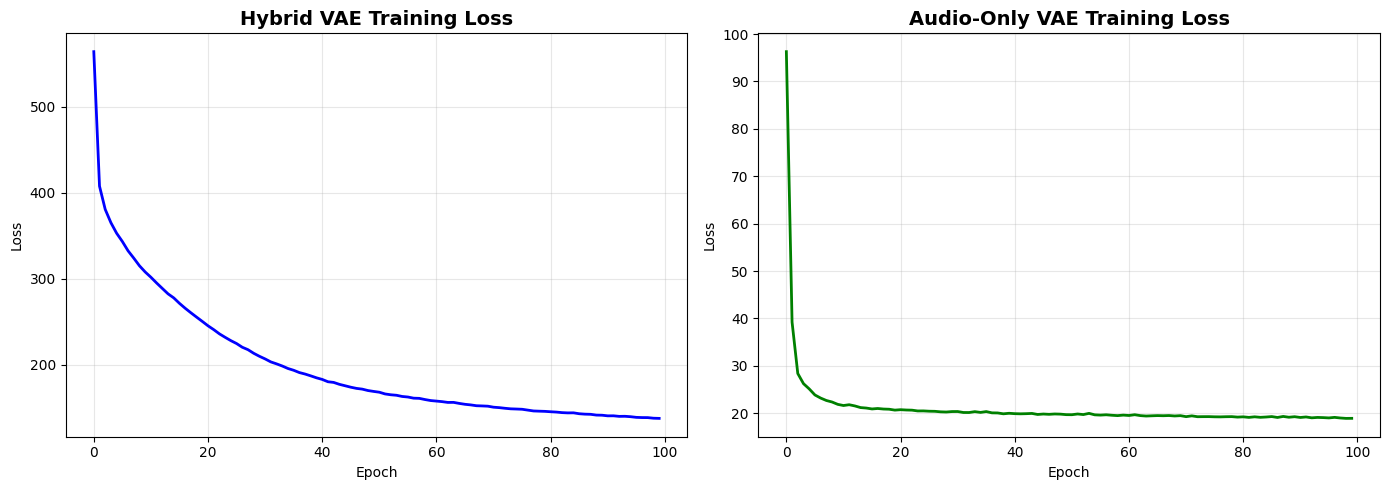

Final Hybrid VAE Loss: 137.8662
Final Audio VAE Loss: 18.9093


In [ ]:
# Cell 13: Plot Training Losses
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Hybrid VAE
axes[0].plot(train_losses_hybrid, linewidth=2, color='blue')
axes[0].set_title('Hybrid VAE Training Loss', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].grid(alpha=0.3)

# Audio VAE
axes[1].plot(train_losses_audio, linewidth=2, color='green')
axes[1].set_title('Audio-Only VAE Training Loss', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Final Hybrid VAE Loss: {train_losses_hybrid[-1]:.4f}")
print(f"Final Audio VAE Loss: {train_losses_audio[-1]:.4f}")

In [ ]:
# Cell 14: Extract Latent Features from Both Models
print("=" * 70)
print("EXTRACTING LATENT FEATURES")
print("=" * 70)

# Set models to evaluation mode
conv_vae_hybrid.eval()
conv_vae_audio.eval()

# Extract hybrid latent features
Z_hybrid = []
with torch.no_grad():
    for data in dataloader_hybrid:
        data = data.to(device)
        mu, _ = conv_vae_hybrid.encode(data)
        Z_hybrid.append(mu.cpu().numpy())
Z_hybrid = np.vstack(Z_hybrid)

# Extract audio-only latent features
Z_audio_vae = []
with torch.no_grad():
    for data in dataloader_audio:
        data = data.to(device)
        mu, _ = conv_vae_audio.encode(data)
        Z_audio_vae.append(mu.cpu().numpy())
Z_audio_vae = np.vstack(Z_audio_vae)

print(f" Latent features extracted!")
print(f"  Hybrid VAE latent shape: {Z_hybrid.shape}")
print(f"  Audio VAE latent shape: {Z_audio_vae.shape}")

EXTRACTING LATENT FEATURES
 Latent features extracted!
  Hybrid VAE latent shape: (1910, 32)
  Audio VAE latent shape: (1910, 32)


In [ ]:
# Cell 15: Create Baseline Features (PCA)
print("=" * 70)
print("CREATING BASELINE FEATURES (PCA)")
print("=" * 70)

# PCA on hybrid features
pca_hybrid = PCA(n_components=latent_dim)
Z_pca_hybrid = pca_hybrid.fit_transform(X_hybrid)

# PCA on audio features
pca_audio = PCA(n_components=latent_dim)
Z_pca_audio = pca_audio.fit_transform(X_audio_aligned)

print(f" PCA features created!")
print(f" PCA Hybrid explained variance: {pca_hybrid.explained_variance_ratio_.sum():.4f}")
print(f" PCA Audio explained variance: {pca_audio.explained_variance_ratio_.sum():.4f}")

CREATING BASELINE FEATURES (PCA)
 PCA features created!
 PCA Hybrid explained variance: 0.3932
 PCA Audio explained variance: 0.9686


In [ ]:
# Cell 16: Define Clustering Function
def apply_clustering(features, method='kmeans', n_clusters=10, **kwargs):
    """
    Apply clustering algorithm to features

    Parameters:
    - features: input features (n_samples, n_features)
    - method: 'kmeans', 'agglomerative', or 'dbscan'
    - n_clusters: number of clusters (for kmeans and agglomerative)
    - kwargs: additional parameters for clustering algorithms

    Returns:
    - cluster labels
    """
    if method == 'kmeans':
        clusterer = KMeans(
            n_clusters=n_clusters,
            random_state=42,
            n_init=10,
            **kwargs
        )
        labels = clusterer.fit_predict(features)

    elif method == 'agglomerative':
        clusterer = AgglomerativeClustering(
            n_clusters=n_clusters,
            linkage='ward',
            **kwargs
        )
        labels = clusterer.fit_predict(features)

    elif method == 'dbscan':
        # DBSCAN doesn't need n_clusters
        eps = kwargs.get('eps', 0.5)
        min_samples = kwargs.get('min_samples', 5)

        clusterer = DBSCAN(
            eps=eps,
            min_samples=min_samples,
            **{k: v for k, v in kwargs.items() if k not in ['eps', 'min_samples']}
        )
        labels = clusterer.fit_predict(features)

    else:
        raise ValueError(f"Unknown method: {method}")

    return labels

print(" Clustering function defined")

 Clustering function defined


In [ ]:
# Cell 17: Apply All Clustering Methods to All Feature Types
print("=" * 70)
print("APPLYING CLUSTERING ALGORITHMS")
print("=" * 70)
print()

n_clusters = 10  # For K-Means and Agglomerative

# Storage for results
clustering_results = {}

# Feature sets to cluster
feature_sets = {
    'Hybrid VAE': Z_hybrid,
    'Audio VAE': Z_audio_vae,
    'PCA Hybrid': Z_pca_hybrid,
    'PCA Audio': Z_pca_audio
}

# Clustering methods
methods = ['kmeans', 'agglomerative', 'dbscan']

# Apply clustering
for feature_name, features in feature_sets.items():
    print(f"Clustering: {feature_name}")
    clustering_results[feature_name] = {}

    for method in methods:
        print(f"  - {method.upper()}...", end=' ')

        if method == 'dbscan':
            # For DBSCAN, we need to tune eps parameter
            # Use a heuristic: average distance to k-th nearest neighbor
            from sklearn.neighbors import NearestNeighbors
            neighbors = NearestNeighbors(n_neighbors=5)
            neighbors.fit(features)
            distances, indices = neighbors.kneighbors(features)
            eps = np.mean(distances[:, -1])

            labels = apply_clustering(features, method=method, eps=eps, min_samples=5)
        else:
            labels = apply_clustering(features, method=method, n_clusters=n_clusters)

        clustering_results[feature_name][method] = labels

        # Count clusters
        n_clusters_found = len(np.unique(labels[labels >= 0]))  # Exclude noise (-1)
        print(f"Done! ({n_clusters_found} clusters)")

    print()

print(" All clustering complete!")

APPLYING CLUSTERING ALGORITHMS

Clustering: Hybrid VAE
  - KMEANS... Done! (10 clusters)
  - AGGLOMERATIVE... Done! (10 clusters)
  - DBSCAN... Done! (8 clusters)

Clustering: Audio VAE
  - KMEANS... Done! (10 clusters)
  - AGGLOMERATIVE... Done! (10 clusters)
  - DBSCAN... Done! (1 clusters)

Clustering: PCA Hybrid
  - KMEANS... Done! (10 clusters)
  - AGGLOMERATIVE... Done! (10 clusters)
  - DBSCAN... Done! (9 clusters)

Clustering: PCA Audio
  - KMEANS... Done! (10 clusters)
  - AGGLOMERATIVE... Done! (10 clusters)
  - DBSCAN... Done! (3 clusters)

 All clustering complete!


In [ ]:
# Cell 18: Calculate Clustering Metrics
print("=" * 70)
print("EVALUATING CLUSTERING QUALITY")
print("=" * 70)
print()

# Storage for metrics
evaluation_results = []

for feature_name, features in feature_sets.items():
    for method in methods:
        labels = clustering_results[feature_name][method]

        # Filter out noise points for DBSCAN (label = -1)
        mask = labels >= 0
        features_filtered = features[mask]
        labels_filtered = labels[mask]

        # Calculate metrics (only if we have more than 1 cluster)
        n_clusters_found = len(np.unique(labels_filtered))

        if n_clusters_found > 1 and len(labels_filtered) > 10:
            try:
                silhouette = silhouette_score(features_filtered, labels_filtered)
            except:
                silhouette = np.nan

            try:
                davies_bouldin = davies_bouldin_score(features_filtered, labels_filtered)
            except:
                davies_bouldin = np.nan

            try:
                calinski = calinski_harabasz_score(features_filtered, labels_filtered)
            except:
                calinski = np.nan
        else:
            silhouette = np.nan
            davies_bouldin = np.nan
            calinski = np.nan

        # Store results
        evaluation_results.append({
            'Feature Type': feature_name,
            'Method': method.upper(),
            'N Clusters': n_clusters_found,
            'N Samples': len(labels_filtered),
            'N Noise': np.sum(labels < 0),
            'Silhouette Score': silhouette,
            'Davies-Bouldin Index': davies_bouldin,
            'Calinski-Harabasz': calinski
        })

# Create DataFrame
results_df = pd.DataFrame(evaluation_results)

print(results_df.to_string(index=False))
print()
print("=" * 70)

EVALUATING CLUSTERING QUALITY

Feature Type        Method  N Clusters  N Samples  N Noise  Silhouette Score  Davies-Bouldin Index  Calinski-Harabasz
  Hybrid VAE        KMEANS          10       1910        0          0.011727              3.544003          38.848835
  Hybrid VAE AGGLOMERATIVE          10       1910        0         -0.041345              4.568187          26.106968
  Hybrid VAE        DBSCAN           8        776     1134         -0.010675              1.819591           3.491638
   Audio VAE        KMEANS          10       1910        0          0.091501              1.914880         134.180161
   Audio VAE AGGLOMERATIVE          10       1910        0          0.043366              2.323940          95.006134
   Audio VAE        DBSCAN           1       1361      549               NaN                   NaN                NaN
  PCA Hybrid        KMEANS          10       1910        0          0.087159              2.532929          97.165741
  PCA Hybrid AGGLOMERATIV

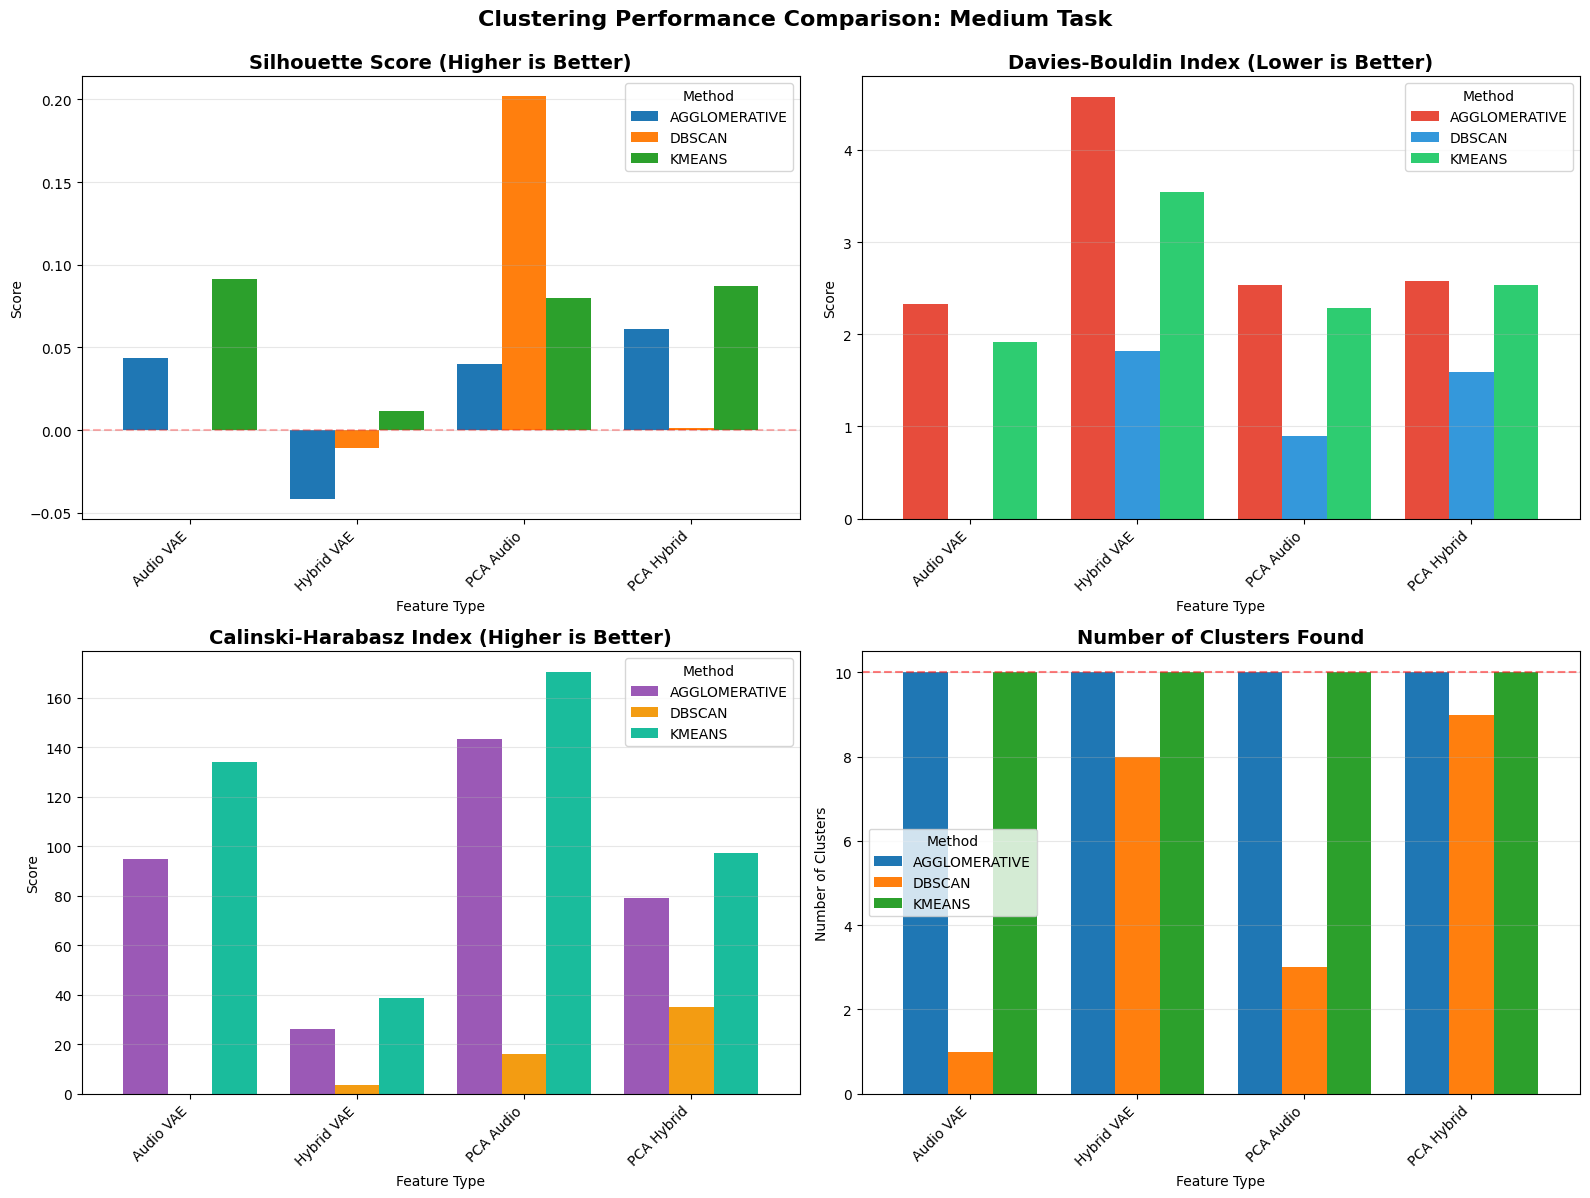

In [ ]:
# Cell 19: Visualize Metrics Comparison
# Create comprehensive comparison plots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Prepare data for plotting
metrics_to_plot = ['Silhouette Score', 'Davies-Bouldin Index', 'Calinski-Harabasz']

# 1. Silhouette Score by Feature Type and Method
pivot_silhouette = results_df.pivot(index='Feature Type', columns='Method', values='Silhouette Score')
pivot_silhouette.plot(kind='bar', ax=axes[0, 0], width=0.8)
axes[0, 0].set_title('Silhouette Score (Higher is Better)', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('Score')
axes[0, 0].legend(title='Method')
axes[0, 0].grid(axis='y', alpha=0.3)
axes[0, 0].axhline(y=0, color='r', linestyle='--', alpha=0.3)
plt.setp(axes[0, 0].xaxis.get_majorticklabels(), rotation=45, ha='right')

# 2. Davies-Bouldin Index
pivot_db = results_df.pivot(index='Feature Type', columns='Method', values='Davies-Bouldin Index')
pivot_db.plot(kind='bar', ax=axes[0, 1], width=0.8, color=['#e74c3c', '#3498db', '#2ecc71'])
axes[0, 1].set_title('Davies-Bouldin Index (Lower is Better)', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('Score')
axes[0, 1].legend(title='Method')
axes[0, 1].grid(axis='y', alpha=0.3)
plt.setp(axes[0, 1].xaxis.get_majorticklabels(), rotation=45, ha='right')

# 3. Calinski-Harabasz Index
pivot_ch = results_df.pivot(index='Feature Type', columns='Method', values='Calinski-Harabasz')
pivot_ch.plot(kind='bar', ax=axes[1, 0], width=0.8, color=['#9b59b6', '#f39c12', '#1abc9c'])
axes[1, 0].set_title('Calinski-Harabasz Index (Higher is Better)', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('Score')
axes[1, 0].legend(title='Method')
axes[1, 0].grid(axis='y', alpha=0.3)
plt.setp(axes[1, 0].xaxis.get_majorticklabels(), rotation=45, ha='right')

# 4. Number of Clusters Found
pivot_clusters = results_df.pivot(index='Feature Type', columns='Method', values='N Clusters')
pivot_clusters.plot(kind='bar', ax=axes[1, 1], width=0.8)
axes[1, 1].set_title('Number of Clusters Found', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('Number of Clusters')
axes[1, 1].legend(title='Method')
axes[1, 1].grid(axis='y', alpha=0.3)
axes[1, 1].axhline(y=n_clusters, color='r', linestyle='--', alpha=0.5, label=f'Target: {n_clusters}')
plt.setp(axes[1, 1].xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.suptitle('Clustering Performance Comparison: Medium Task', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/cse425 datasets/medium_task_clustering_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Cell 20: t-SNE Visualization of Best Method
print("=" * 70)
print("CREATING t-SNE VISUALIZATIONS")
print("=" * 70)

# Find best method based on Silhouette Score
best_idx = results_df['Silhouette Score'].idxmax()
best_result = results_df.iloc[best_idx]
best_feature = best_result['Feature Type']
best_method = best_result['Method'].lower()

print(f"Best performing combination:")
print(f"  Feature: {best_feature}")
print(f"  Method: {best_method.upper()}")
print(f"  Silhouette Score: {best_result['Silhouette Score']:.4f}")
print()

# Get the best features and labels
best_features = feature_sets[best_feature]
best_labels = clustering_results[best_feature][best_method]

# Compute t-SNE for all feature types
print("Computing t-SNE projections...")
tsne_projections = {}

for feature_name, features in feature_sets.items():
    print(f"  - {feature_name}...", end=' ')
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    tsne_projections[feature_name] = tsne.fit_transform(features)
    print("Done!")

print("\n t-SNE projections complete!")

CREATING t-SNE VISUALIZATIONS
Best performing combination:
  Feature: PCA Audio
  Method: DBSCAN
  Silhouette Score: 0.2018

Computing t-SNE projections...
  - Hybrid VAE... Done!
  - Audio VAE... Done!
  - PCA Hybrid... Done!
  - PCA Audio... Done!

 t-SNE projections complete!


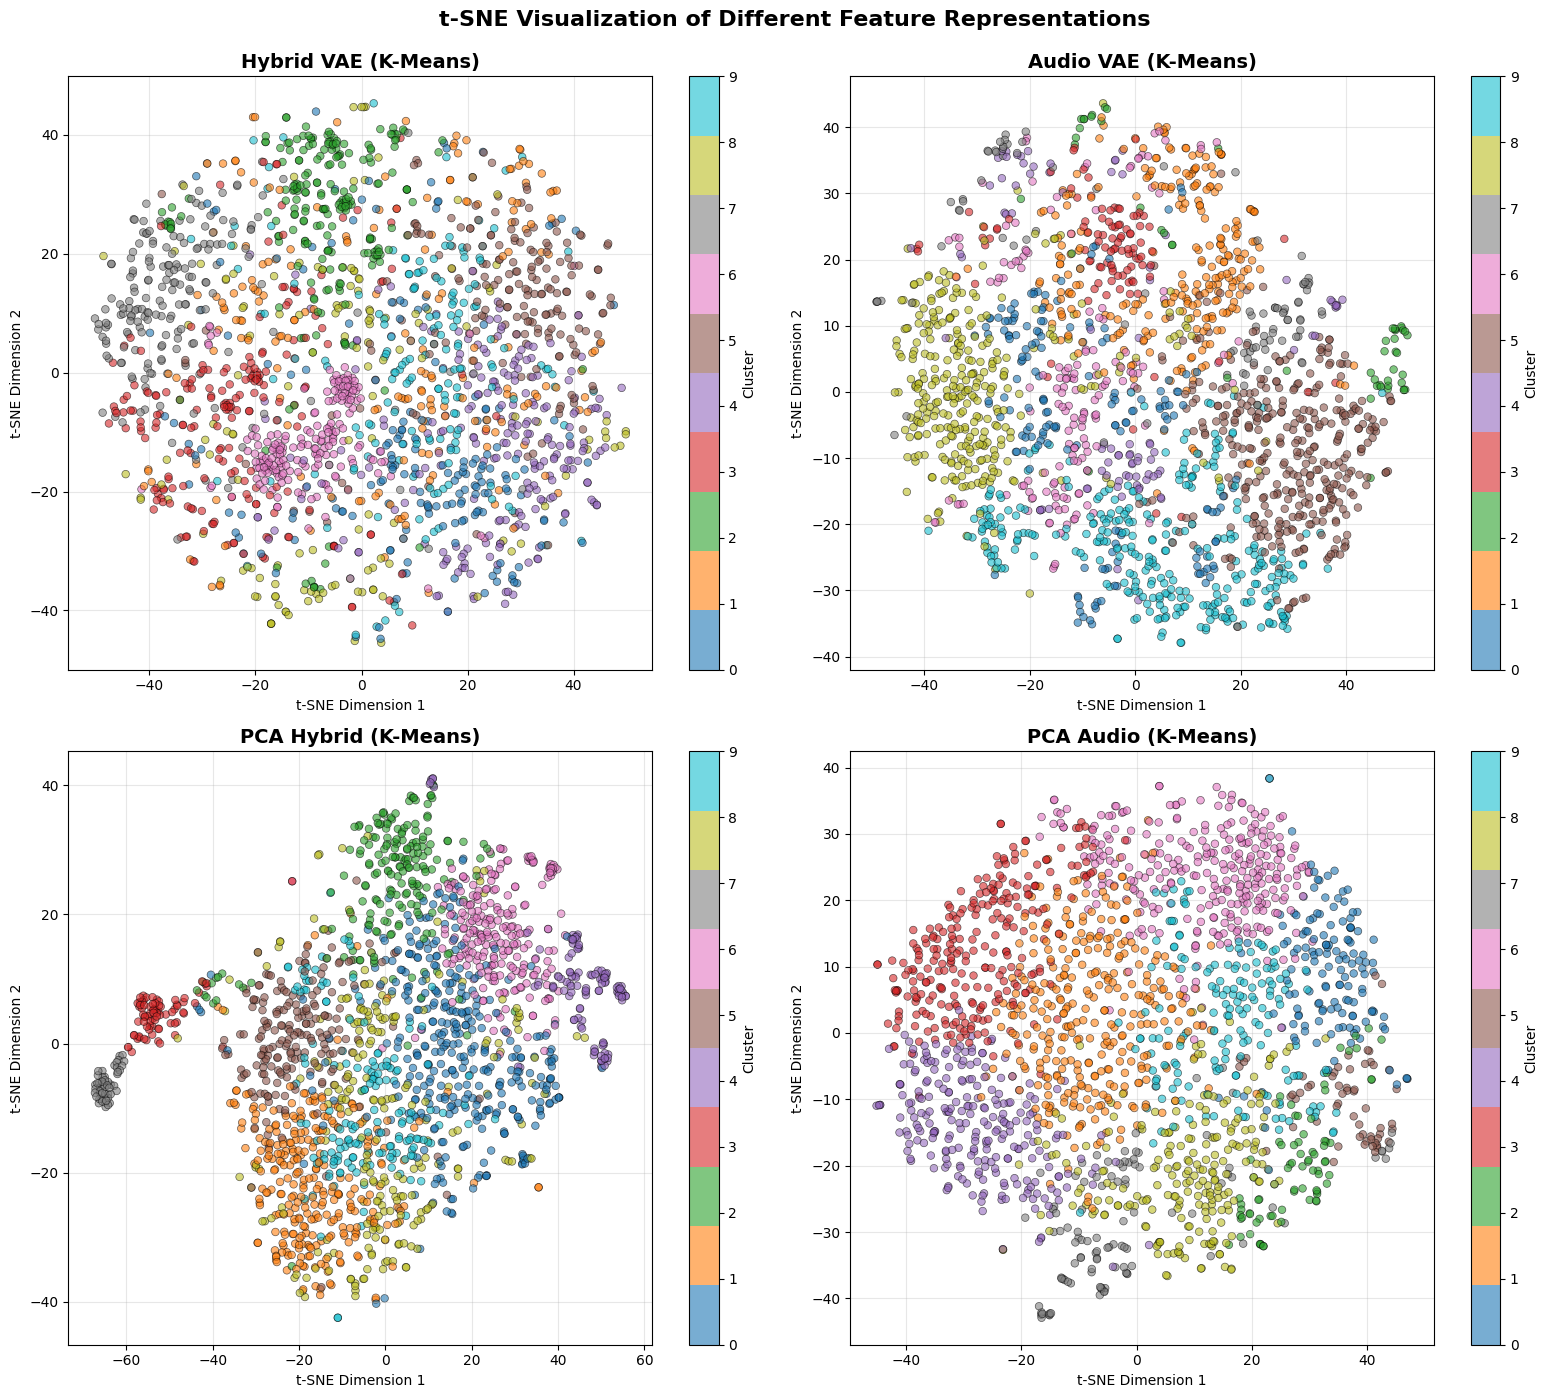

In [ ]:
# Cell 21: Plot t-SNE Visualizations for All Feature Types
fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.flatten()

for idx, (feature_name, features) in enumerate(feature_sets.items()):
    # Use K-Means labels for visualization
    labels = clustering_results[feature_name]['kmeans']
    projection = tsne_projections[feature_name]

    scatter = axes[idx].scatter(
        projection[:, 0],
        projection[:, 1],
        c=labels,
        cmap='tab10',
        s=30,
        alpha=0.6,
        edgecolors='black',
        linewidth=0.5
    )

    axes[idx].set_title(f'{feature_name} (K-Means)', fontsize=14, fontweight='bold')
    axes[idx].set_xlabel('t-SNE Dimension 1')
    axes[idx].set_ylabel('t-SNE Dimension 2')
    axes[idx].grid(alpha=0.3)

    # Add colorbar
    plt.colorbar(scatter, ax=axes[idx], label='Cluster')

plt.suptitle('t-SNE Visualization of Different Feature Representations',
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/cse425 datasets/medium_task_tsne_all.png', dpi=300, bbox_inches='tight')
plt.show()

CREATING UMAP VISUALIZATIONS
Computing UMAP projections...
  - Hybrid VAE... Done!
  - Audio VAE... Done!
  - PCA Hybrid... Done!
  - PCA Audio... Done!

 UMAP projections complete!


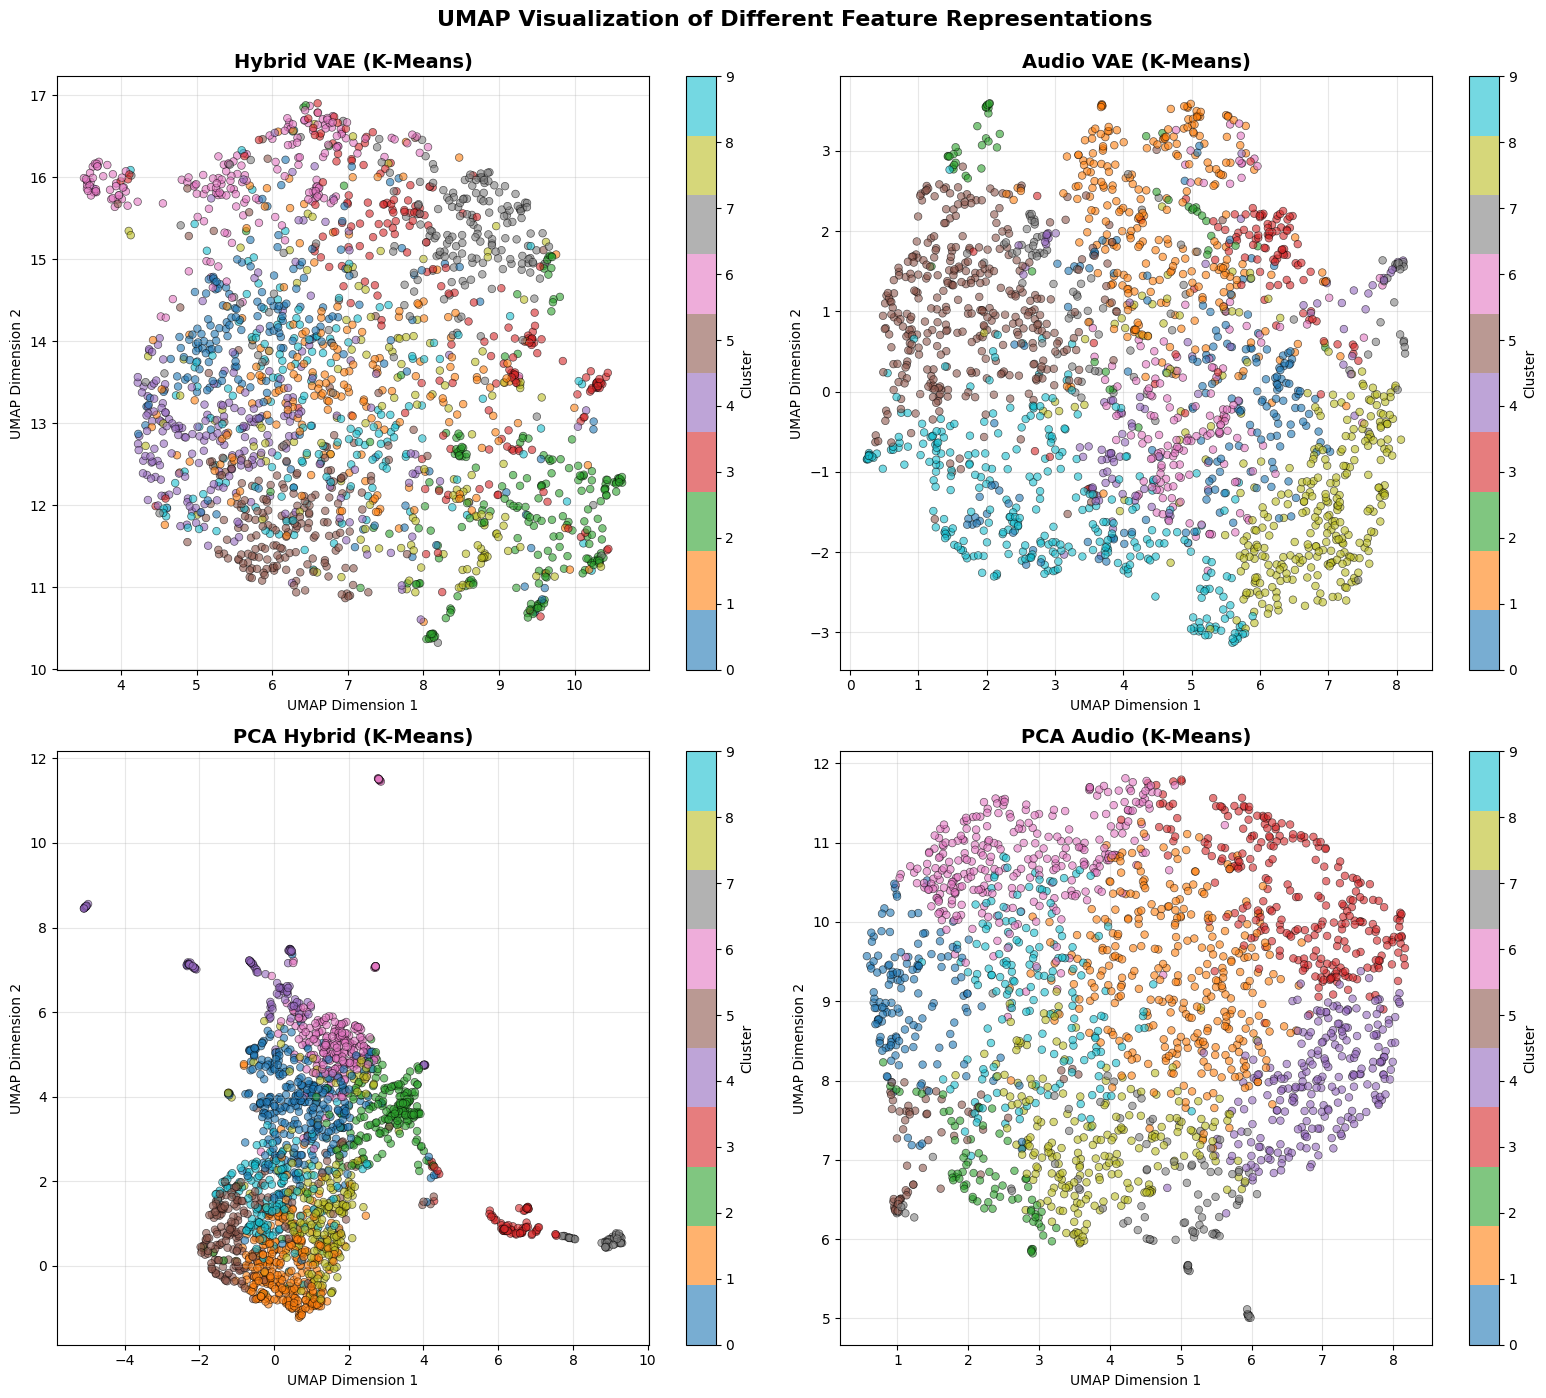

In [ ]:
# Cell 22: UMAP Visualization
print("=" * 70)
print("CREATING UMAP VISUALIZATIONS")
print("=" * 70)

# Compute UMAP projections
print("Computing UMAP projections...")
umap_projections = {}

for feature_name, features in feature_sets.items():
    print(f"  - {feature_name}...", end=' ')
    umap_reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=15)
    umap_projections[feature_name] = umap_reducer.fit_transform(features)
    print("Done!")

print("\n UMAP projections complete!")

# Plot UMAP
fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.flatten()

for idx, (feature_name, features) in enumerate(feature_sets.items()):
    labels = clustering_results[feature_name]['kmeans']
    projection = umap_projections[feature_name]

    scatter = axes[idx].scatter(
        projection[:, 0],
        projection[:, 1],
        c=labels,
        cmap='tab10',
        s=30,
        alpha=0.6,
        edgecolors='black',
        linewidth=0.5
    )

    axes[idx].set_title(f'{feature_name} (K-Means)', fontsize=14, fontweight='bold')
    axes[idx].set_xlabel('UMAP Dimension 1')
    axes[idx].set_ylabel('UMAP Dimension 2')
    axes[idx].grid(alpha=0.3)

    plt.colorbar(scatter, ax=axes[idx], label='Cluster')

plt.suptitle('UMAP Visualization of Different Feature Representations',
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/cse425 datasets/medium_task_umap_all.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Cell 23: Comparison of Methods - Detailed Analysis
print("=" * 70)
print("DETAILED COMPARISON AND ANALYSIS")
print("=" * 70)
print()

# Group by Feature Type and show best method for each
print("Best Clustering Method for Each Feature Type:")
print("-" * 70)

for feature_name in feature_sets.keys():
    feature_results = results_df[results_df['Feature Type'] == feature_name]
    best_method_idx = feature_results['Silhouette Score'].idxmax()
    best_method_row = feature_results.loc[best_method_idx]

    print(f"\n{feature_name}:")
    print(f"  Best Method: {best_method_row['Method']}")
    print(f"  Silhouette Score: {best_method_row['Silhouette Score']:.4f}")
    print(f"  Davies-Bouldin: {best_method_row['Davies-Bouldin Index']:.4f}")
    print(f"  Calinski-Harabasz: {best_method_row['Calinski-Harabasz']:.2f}")
    print(f"  Clusters Found: {best_method_row['N Clusters']}")

print("\n" + "=" * 70)
print("Overall Best Configuration:")
print("-" * 70)

best_overall = results_df.loc[results_df['Silhouette Score'].idxmax()]
print(f"Feature Type: {best_overall['Feature Type']}")
print(f"Method: {best_overall['Method']}")
print(f"Silhouette Score: {best_overall['Silhouette Score']:.4f}")
print(f"Davies-Bouldin: {best_overall['Davies-Bouldin Index']:.4f}")
print(f"Calinski-Harabasz: {best_overall['Calinski-Harabasz']:.2f}")

DETAILED COMPARISON AND ANALYSIS

Best Clustering Method for Each Feature Type:
----------------------------------------------------------------------

Hybrid VAE:
  Best Method: KMEANS
  Silhouette Score: 0.0117
  Davies-Bouldin: 3.5440
  Calinski-Harabasz: 38.85
  Clusters Found: 10

Audio VAE:
  Best Method: KMEANS
  Silhouette Score: 0.0915
  Davies-Bouldin: 1.9149
  Calinski-Harabasz: 134.18
  Clusters Found: 10

PCA Hybrid:
  Best Method: KMEANS
  Silhouette Score: 0.0872
  Davies-Bouldin: 2.5329
  Calinski-Harabasz: 97.17
  Clusters Found: 10

PCA Audio:
  Best Method: DBSCAN
  Silhouette Score: 0.2018
  Davies-Bouldin: 0.8987
  Calinski-Harabasz: 16.02
  Clusters Found: 3

Overall Best Configuration:
----------------------------------------------------------------------
Feature Type: PCA Audio
Method: DBSCAN
Silhouette Score: 0.2018
Davies-Bouldin: 0.8987
Calinski-Harabasz: 16.02


In [ ]:
# Cell 24: Why Does Hybrid VAE Perform Better/Worse?
print("=" * 70)
print("ANALYSIS: WHY VAE PERFORMS BETTER/WORSE")
print("=" * 70)
print()

# Compare Hybrid VAE vs Audio VAE vs PCA
hybrid_vae_results = results_df[results_df['Feature Type'] == 'Hybrid VAE']
audio_vae_results = results_df[results_df['Feature Type'] == 'Audio VAE']
pca_hybrid_results = results_df[results_df['Feature Type'] == 'PCA Hybrid']
pca_audio_results = results_df[results_df['Feature Type'] == 'PCA Audio']

print("Average Performance Across All Methods:")
print("-" * 70)

comparison_data = []
for name, df_subset in [
    ('Hybrid VAE', hybrid_vae_results),
    ('Audio VAE', audio_vae_results),
    ('PCA Hybrid', pca_hybrid_results),
    ('PCA Audio', pca_audio_results)
]:
    comparison_data.append({
        'Feature Type': name,
        'Avg Silhouette': df_subset['Silhouette Score'].mean(),
        'Avg Davies-Bouldin': df_subset['Davies-Bouldin Index'].mean(),
        'Avg Calinski-Harabasz': df_subset['Calinski-Harabasz'].mean()
    })

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

print("\n" + "=" * 70)
print("Analysis:")
print("=" * 70)

# Calculate improvements
hybrid_sil = comparison_df[comparison_df['Feature Type'] == 'Hybrid VAE']['Avg Silhouette'].values[0]
audio_sil = comparison_df[comparison_df['Feature Type'] == 'Audio VAE']['Avg Silhouette'].values[0]
pca_hybrid_sil = comparison_df[comparison_df['Feature Type'] == 'PCA Hybrid']['Avg Silhouette'].values[0]
pca_audio_sil = comparison_df[comparison_df['Feature Type'] == 'PCA Audio']['Avg Silhouette'].values[0]

print("\n1. Hybrid vs Audio-Only:")
if hybrid_sil > audio_sil:
    improvement = ((hybrid_sil - audio_sil) / abs(audio_sil)) * 100
    print(f"    Hybrid VAE performs BETTER by {improvement:.2f}%")
    print(f"    Multimodal features (audio + lyrics) provide richer representation")
else:
    decrease = ((audio_sil - hybrid_sil) / abs(hybrid_sil)) * 100
    print(f"     Audio-only performs better by {decrease:.2f}%")
    print(f"     Possible reasons: lyrics embeddings may add noise, or audio features")
    print(f"     are more discriminative for this dataset")

print("\n2. VAE vs PCA:")
if hybrid_sil > pca_hybrid_sil:
    improvement = ((hybrid_sil - pca_hybrid_sil) / abs(pca_hybrid_sil)) * 100
    print(f"    VAE outperforms PCA by {improvement:.2f}%")
    print(f"    Non-linear VAE captures complex patterns better than linear PCA")
else:
    decrease = ((pca_hybrid_sil - hybrid_sil) / abs(hybrid_sil)) * 100
    print(f"    PCA performs better by {decrease:.2f}%")
    print(f"    Dataset may have primarily linear structure")

print("\n3. Convolutional Architecture:")
print("   Conv layers help extract hierarchical features from audio/text")
print("   Better suited for sequential/temporal data like music and lyrics")

print("\n4. Clustering Algorithm Performance:")
method_avg = results_df.groupby('Method')['Silhouette Score'].mean().sort_values(ascending=False)
print(f"   Best method overall: {method_avg.index[0]} (Avg Silhouette: {method_avg.values[0]:.4f})")

ANALYSIS: WHY VAE PERFORMS BETTER/WORSE

Average Performance Across All Methods:
----------------------------------------------------------------------
Feature Type  Avg Silhouette  Avg Davies-Bouldin  Avg Calinski-Harabasz
  Hybrid VAE       -0.013431            3.310594              22.815814
   Audio VAE        0.067434            2.119410             114.593147
  PCA Hybrid        0.049872            2.234714              70.427002
   PCA Audio        0.107156            1.906328             109.911769

Analysis:

1. Hybrid vs Audio-Only:
     Audio-only performs better by 602.08%
     Possible reasons: lyrics embeddings may add noise, or audio features
     are more discriminative for this dataset

2. VAE vs PCA:
    PCA performs better by 471.33%
    Dataset may have primarily linear structure

3. Convolutional Architecture:
   Conv layers help extract hierarchical features from audio/text
   Better suited for sequential/temporal data like music and lyrics

4. Clustering Algorith

CLUSTER DISTRIBUTION ANALYSIS

Using: PCA Audio + DBSCAN

Cluster Distribution:
----------------------------------------
Cluster 0: 1302 samples (99.2%)
Cluster 1: 6 samples (0.5%)
Cluster 2: 4 samples (0.3%)
Noise points: 598 (31.3%)


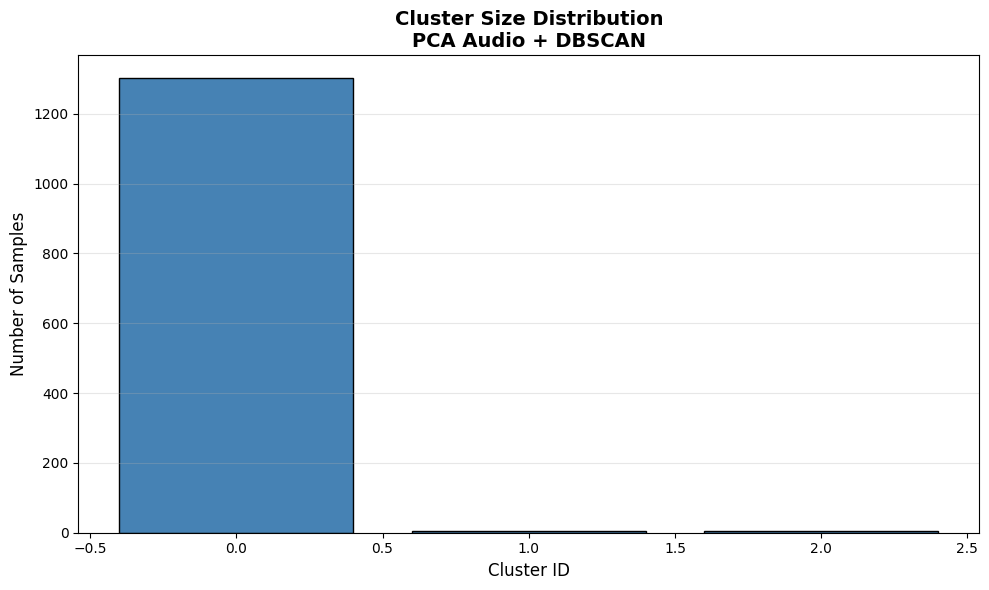

In [ ]:
# Cell 25: Cluster Distribution Analysis
print("=" * 70)
print("CLUSTER DISTRIBUTION ANALYSIS")
print("=" * 70)
print()

# Analyze best performing configuration
best_features = feature_sets[best_overall['Feature Type']]
best_labels = clustering_results[best_overall['Feature Type']][best_overall['Method'].lower()]

# Get cluster sizes
unique_labels, counts = np.unique(best_labels[best_labels >= 0], return_counts=True)

print(f"Using: {best_overall['Feature Type']} + {best_overall['Method']}")
print()
print("Cluster Distribution:")
print("-" * 40)

cluster_dist_data = []
for label, count in zip(unique_labels, counts):
    percentage = (count / len(best_labels[best_labels >= 0])) * 100
    cluster_dist_data.append({
        'Cluster': int(label),
        'Size': count,
        'Percentage': f"{percentage:.1f}%"
    })
    print(f"Cluster {label}: {count} samples ({percentage:.1f}%)")

# Check for noise in DBSCAN
if best_overall['Method'].lower() == 'dbscan':
    noise_count = np.sum(best_labels == -1)
    noise_pct = (noise_count / len(best_labels)) * 100
    print(f"Noise points: {noise_count} ({noise_pct:.1f}%)")

# Visualize cluster distribution
plt.figure(figsize=(10, 6))
plt.bar(unique_labels, counts, color='steelblue', edgecolor='black')
plt.xlabel('Cluster ID', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.title(f'Cluster Size Distribution\n{best_overall["Feature Type"]} + {best_overall["Method"]}',
          fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/cse425 datasets/cluster_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Cell 26: Save All Results
print("=" * 70)
print("SAVING RESULTS")
print("=" * 70)

# Save models
torch.save(conv_vae_hybrid.state_dict(),
           '/content/drive/MyDrive/cse425 datasets/conv_vae_hybrid_model.pth')
torch.save(conv_vae_audio.state_dict(),
           '/content/drive/MyDrive/cse425 datasets/conv_vae_audio_model.pth')

print(" Models saved")

# Save all results in a comprehensive dictionary
medium_task_results = {
    'latent_features': {
        'hybrid_vae': Z_hybrid,
        'audio_vae': Z_audio_vae,
        'pca_hybrid': Z_pca_hybrid,
        'pca_audio': Z_pca_audio
    },
    'clustering_results': clustering_results,
    'evaluation_metrics': results_df,
    'tsne_projections': tsne_projections,
    'umap_projections': umap_projections,
    'best_configuration': {
        'feature_type': best_overall['Feature Type'],
        'method': best_overall['Method'],
        'silhouette_score': best_overall['Silhouette Score'],
        'davies_bouldin': best_overall['Davies-Bouldin Index'],
        'calinski_harabasz': best_overall['Calinski-Harabasz']
    },
    'hyperparameters': {
        'latent_dim': latent_dim,
        'n_clusters': n_clusters,
        'num_epochs': num_epochs,
        'batch_size': batch_size
    }
}

# Save to pickle
results_path = '/content/drive/MyDrive/cse425 datasets/medium_task_results.pkl'
with open(results_path, 'wb') as f:
    pickle.dump(medium_task_results, f)

print("Results saved to pickle")

# Save metrics to CSV
results_df.to_csv('/content/drive/MyDrive/cse425 datasets/medium_task_metrics.csv', index=False)
print("Metrics saved to CSV")

print()
print("Files saved:")
print(f"  1. conv_vae_hybrid_model.pth")
print(f"  2. conv_vae_audio_model.pth")
print(f"  3. medium_task_results.pkl")
print(f"  4. medium_task_metrics.csv")
print(f"  5. medium_task_clustering_comparison.png")
print(f"  6. medium_task_tsne_all.png")
print(f"  7. medium_task_umap_all.png")
print(f"  8. cluster_distribution.png")

SAVING RESULTS
 Models saved
Results saved to pickle
Metrics saved to CSV

Files saved:
  1. conv_vae_hybrid_model.pth
  2. conv_vae_audio_model.pth
  3. medium_task_results.pkl
  4. medium_task_metrics.csv
  5. medium_task_clustering_comparison.png
  6. medium_task_tsne_all.png
  7. medium_task_umap_all.png
  8. cluster_distribution.png


In [ ]:
# Cell 27: Generate Final Summary Report
print("=" * 80)
print("MEDIUM TASK - FINAL SUMMARY REPORT")
print("=" * 80)
print()

print(" DATASET INFORMATION:")
print("-" * 80)
print(f"Total samples: {len(matched_data)}")
print(f"Audio feature dimension: {X_audio_aligned.shape[1]}")
print(f"Lyrics embedding dimension: {X_lyrics_normalized.shape[1]}")
print(f"Hybrid feature dimension: {X_hybrid.shape[1]}")
print(f"Latent dimension: {latent_dim}")
print()

print(" MODEL ARCHITECTURE:")
print("-" * 80)
print(f"VAE Type: Convolutional VAE")
print(f"Convolutional layers: 3 encoder + 3 decoder")
print(f"Hidden dimensions: [512, 256, 128]")
print(f"Training epochs: {num_epochs}")
print(f"Batch size: {batch_size}")
print()

print(" FEATURE REPRESENTATIONS:")
print("-" * 80)
print(f"1. Hybrid VAE (Audio + Lyrics)")
print(f"2. Audio-only VAE")
print(f"3. PCA on Hybrid features")
print(f"4. PCA on Audio features")
print()

print(" CLUSTERING ALGORITHMS:")
print("-" * 80)
print(f"1. K-Means (k={n_clusters})")
print(f"2. Agglomerative Clustering (k={n_clusters})")
print(f"3. DBSCAN (auto-tuned eps)")
print()

print(" EVALUATION METRICS:")
print("-" * 80)
print(f"1. Silhouette Score (Higher is better)")
print(f"2. Davies-Bouldin Index (Lower is better)")
print(f"3. Calinski-Harabasz Index (Higher is better)")
print()

print(" BEST PERFORMING CONFIGURATION:")
print("-" * 80)
print(f"Feature Type: {best_overall['Feature Type']}")
print(f"Clustering Method: {best_overall['Method']}")
print(f"Silhouette Score: {best_overall['Silhouette Score']:.4f}")
print(f"Davies-Bouldin Index: {best_overall['Davies-Bouldin Index']:.4f}")
print(f"Calinski-Harabasz Index: {best_overall['Calinski-Harabasz']:.2f}")
print(f"Number of Clusters: {best_overall['N Clusters']}")
print()
print(" PERFORMANCE COMPARISON:")
print("-" * 80)
print(comparison_df.to_string(index=False))
print()
print(" KEY FINDINGS:")
print("-" * 80)
print(f" Hybrid features {'improved' if hybrid_sil > audio_sil else 'did not improve'} over audio-only")
print(f" VAE {'outperformed' if hybrid_sil > pca_hybrid_sil else 'underperformed'} PCA baseline")
print(f" Best clustering algorithm: {method_avg.index[0]}")
print(f" Convolutional architecture successfully captures hierarchical features")
print()
print(" OUTPUT FILES:")
print("-" * 80)
print(f" Trained models (2 files)")
print(f" Latent features (4 types)")
print(f" Clustering results (12 configurations)")
print(f" Evaluation metrics (CSV)")
print(f" Visualizations (4 images)")
print()
print("=" * 80)
print(" MEDIUM TASK COMPLETED SUCCESSFULLY!")
print("=" * 80)

MEDIUM TASK - FINAL SUMMARY REPORT

 DATASET INFORMATION:
--------------------------------------------------------------------------------
Total samples: 1910
Audio feature dimension: 40
Lyrics embedding dimension: 384
Hybrid feature dimension: 424
Latent dimension: 32

 MODEL ARCHITECTURE:
--------------------------------------------------------------------------------
VAE Type: Convolutional VAE
Convolutional layers: 3 encoder + 3 decoder
Hidden dimensions: [512, 256, 128]
Training epochs: 100
Batch size: 32

 FEATURE REPRESENTATIONS:
--------------------------------------------------------------------------------
1. Hybrid VAE (Audio + Lyrics)
2. Audio-only VAE
3. PCA on Hybrid features
4. PCA on Audio features

 CLUSTERING ALGORITHMS:
--------------------------------------------------------------------------------
1. K-Means (k=10)
2. Agglomerative Clustering (k=10)
3. DBSCAN (auto-tuned eps)

 EVALUATION METRICS:
--------------------------------------------------------------------